In [ ]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning and SHAP
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report
import shap

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

# Create output directory
output_dir = Path("../../Results/Advanced_Analysis/feature_importance")
output_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")


Libraries imported successfully


In [ ]:
# Load event log
log_path = "../../Dataset/BPI Challenge 2017.xes"
log = pm4py.read_xes(log_path)
df = pm4py.convert_to_dataframe(log)

# Ensure timestamp is datetime
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True)

# Sort by case and timestamp
df = df.sort_values(['case:concept:name', 'time:timestamp'])

print(f"Loaded {len(df):,} events")
print(f"Number of cases: {df['case:concept:name'].nunique():,}")
print(f"Number of unique activities: {df['concept:name'].nunique()}")
print(f"Number of unique resources: {df['org:resource'].nunique():,}")


Loaded 1,202,267 events
Number of cases: 31,509
Number of unique activities: 26
Number of unique resources: 149


In [ ]:
case_features = df.groupby('case:concept:name').agg({
    'time:timestamp': ['min', 'max'],
    'concept:name': lambda x: list(x),  # Activity sequence
    'org:resource': lambda x: list(x),  # Resource sequence
    'case:LoanGoal': 'first',
    'case:ApplicationType': 'first',
    'case:RequestedAmount': 'first'
}).reset_index()

case_features.columns = ['case_id', 'start_time', 'end_time', 'activity_sequence', 
                        'resource_sequence', 'loan_goal', 'app_type', 'requested_amount']

# Calculate case duration
case_features['duration_days'] = (case_features['end_time'] - case_features['start_time']).dt.total_seconds() / (24 * 3600)

# Classify outcomes based on whether endpoint activities appear anywhere in the trace
# Priority: Denied > Cancelled > Pending (if multiple endpoints appear)
def classify_outcome(activities):
    # Check if activities is None or empty
    if activities is None:
        return 'Unknown'
    try:
        if len(activities) == 0:
            return 'Unknown'
    except (TypeError, AttributeError):
        return 'Unknown'
    
    # Check if any endpoint activity appears in the trace
    activities_set = set(activities)
    
    if 'A_Denied' in activities_set:
        return 'Denied'
    if 'A_Cancelled' in activities_set:
        return 'Cancelled'
    if 'A_Pending' in activities_set:
        return 'Pending'
    return 'Other'

case_features['outcome'] = case_features['activity_sequence'].apply(classify_outcome)

print(f"Prepared {len(case_features):,} cases")
print(f"Outcome distribution:")
print(case_features['outcome'].value_counts())


Prepared 31,509 cases
Outcome distribution:
outcome
Pending      17228
Cancelled    10431
Denied        3752
Other           98
Name: count, dtype: int64


In [ ]:
# Create feature engineering function
def create_features(case_features):
    """Create comprehensive feature set for prediction"""
    features_df = case_features.copy()
    
    features_df['requested_amount'] = pd.to_numeric(features_df['requested_amount'], errors='coerce').fillna(0)
    
    features_df['case_length'] = features_df['activity_sequence'].apply(len)
    features_df['num_unique_activities'] = features_df['activity_sequence'].apply(lambda x: len(set(x)))
    features_df['num_unique_resources'] = features_df['resource_sequence'].apply(lambda x: len(set(x)))
    
    # Temporal features
    features_df['start_month'] = features_df['start_time'].dt.month

    features_df['num_validate_events'] = features_df['activity_sequence'].apply(
        lambda x: sum(1 for a in x if 'Validate' in str(a))
    )
    
    # Encode categorical variables
    le_loan_goal = LabelEncoder()
    le_app_type = LabelEncoder()
    
    features_df['loan_goal_encoded'] = le_loan_goal.fit_transform(features_df['loan_goal'].fillna('Unknown'))
    features_df['app_type_encoded'] = le_app_type.fit_transform(features_df['app_type'].fillna('Unknown'))
    
    return features_df, le_loan_goal, le_app_type

# Create features
features_df, le_loan_goal, le_app_type = create_features(case_features)

print(f"Created features for {len(features_df):,} cases")
print(f"Feature columns: {len([c for c in features_df.columns if c not in ['case_id', 'start_time', 'end_time', 'activity_sequence', 'resource_sequence', 'last_activity', 'first_activity', 'loan_goal', 'app_type', 'outcome', 'duration_days']])} features")


Created features for 31,509 cases
Feature columns: 10 features


In [ ]:
# Prepare feature columns for modeling
feature_cols = [
    'requested_amount',
    'case_length',
    'num_unique_activities',
    'num_unique_resources',
    'start_month',
    'loan_goal_encoded',
    'app_type_encoded',
    'num_validate_events',
]

# Remove cases with missing target values
features_df_clean = features_df.dropna(subset=['duration_days', 'outcome'])

print(f"Cases with complete data: {len(features_df_clean):,}")
print(f"\nFeature statistics:")
print(features_df_clean[feature_cols].describe())


Cases with complete data: 31,509

Feature statistics:
       requested_amount   case_length  num_unique_activities  \
count      31509.000000  31509.000000           31509.000000   
mean       16233.743989     38.156305              15.532324   
std        15422.246299     16.715308               2.493093   
min            0.000000     10.000000               8.000000   
25%         6000.000000     25.000000              13.000000   
50%        12500.000000     35.000000              16.000000   
75%        21000.000000     47.000000              18.000000   
max       450000.000000    180.000000              21.000000   

       num_unique_resources   start_month  loan_goal_encoded  \
count          31509.000000  31509.000000       31509.000000   
mean               6.976039      6.745470           5.988924   
std                3.277325      3.340266           3.448423   
min                1.000000      1.000000           0.000000   
25%                4.000000      4.000000        

In [ ]:
# Model 1: Predict Case Duration (Regression)
X_duration = features_df_clean[feature_cols].fillna(0)
y_duration = features_df_clean['duration_days']

# Split data
X_train_dur, X_test_dur, y_train_dur, y_test_dur = train_test_split(
    X_duration, y_duration, test_size=0.2, random_state=42
)

# Train Random Forest Regressor
rf_duration = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_duration.fit(X_train_dur, y_train_dur)

# Evaluate
y_pred_dur = rf_duration.predict(X_test_dur)
mae = mean_absolute_error(y_test_dur, y_pred_dur)
r2 = r2_score(y_test_dur, y_pred_dur)

print("=== Case Duration Prediction Model ===")
print(f"Mean Absolute Error: {mae:.2f} days")
print(f"R² Score: {r2:.4f}")
print(f"Average case duration: {y_test_dur.mean():.2f} days")


=== Case Duration Prediction Model ===
Mean Absolute Error: 6.23 days
R² Score: 0.4490
Average case duration: 21.98 days


In [ ]:
# Model 2: Predict Case Outcome (Classification)
# Filter to cases with known outcomes (exclude 'Unknown' and 'Other')
outcome_df = features_df_clean[features_df_clean['outcome'].isin(['Cancelled', 'Denied', 'Pending'])].copy()

X_outcome = outcome_df[feature_cols].fillna(0)
y_outcome = outcome_df['outcome']

# Split data
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
    X_outcome, y_outcome, test_size=0.2, random_state=42, stratify=y_outcome
)

# Train Random Forest Classifier
rf_outcome = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_outcome.fit(X_train_out, y_train_out)

# Evaluate
y_pred_out = rf_outcome.predict(X_test_out)
accuracy = accuracy_score(y_test_out, y_pred_out)

print("=== Case Outcome Prediction Model ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_out, y_pred_out))


=== Case Outcome Prediction Model ===
Accuracy: 0.8703

Classification Report:
              precision    recall  f1-score   support

   Cancelled       0.98      0.92      0.95      2086
      Denied       0.66      0.30      0.41       751
     Pending       0.84      0.96      0.90      3446

    accuracy                           0.87      6283
   macro avg       0.83      0.73      0.75      6283
weighted avg       0.86      0.87      0.85      6283



In [ ]:
# SHAP Analysis for Duration Model
print("Computing SHAP values for duration model (this may take a while)...")

# Create SHAP explainer
explainer_duration = shap.TreeExplainer(rf_duration)
shap_values_duration = explainer_duration.shap_values(X_test_dur)

print("SHAP values computed for duration model")


Computing SHAP values for duration model (this may take a while)...
SHAP values computed for duration model


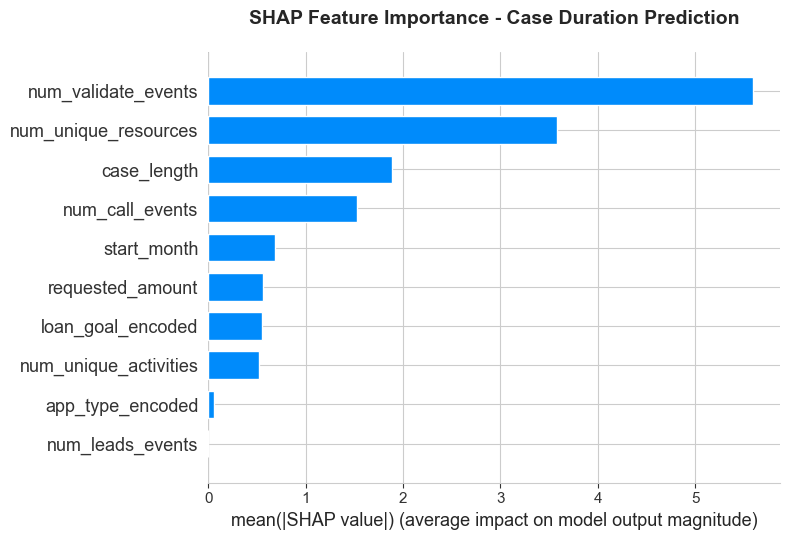

Saved: shap_duration_summary_bar.png


In [ ]:
# SHAP Summary Plot for Duration Model
fig, ax = plt.subplots(figsize=(14, 10))
shap.summary_plot(shap_values_duration, X_test_dur, feature_names=feature_cols, 
                 show=False, plot_type="bar", max_display=15)
plt.title('SHAP Feature Importance - Case Duration Prediction', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'shap_duration_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: shap_duration_summary_bar.png")


In [ ]:
# SHAP Analysis for Outcome Model
print("Computing SHAP values for outcome model (this may take a while)...")

# Create SHAP explainer
explainer_outcome = shap.TreeExplainer(rf_outcome)
shap_values_outcome = explainer_outcome.shap_values(X_test_out)

print("SHAP values computed for outcome model")


Computing SHAP values for outcome model (this may take a while)...
SHAP values computed for outcome model


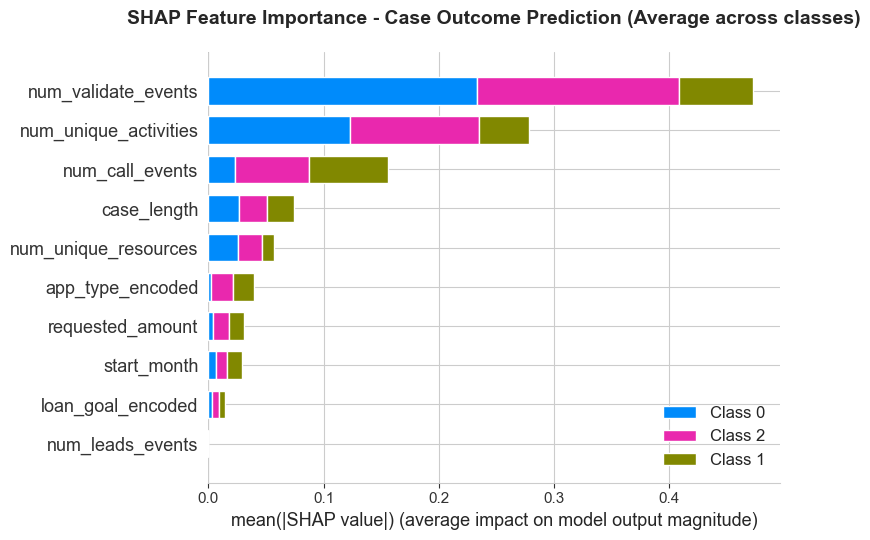

Saved: shap_outcome_summary_bar.png


In [ ]:
# SHAP Summary Plot for Outcome Model (average across classes)
# For multi-class, we'll use the mean absolute SHAP values
if isinstance(shap_values_outcome, list):
    # Multi-class: average absolute SHAP values across classes
    shap_values_outcome_mean = np.mean([np.abs(sv) for sv in shap_values_outcome], axis=0)
else:
    shap_values_outcome_mean = np.abs(shap_values_outcome)

fig, ax = plt.subplots(figsize=(14, 10))
shap.summary_plot(shap_values_outcome_mean, X_test_out, feature_names=feature_cols, 
                 show=False, plot_type="bar", max_display=15)
plt.title('SHAP Feature Importance - Case Outcome Prediction (Average across classes)', 
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'shap_outcome_summary_bar.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: shap_outcome_summary_bar.png")


In [ ]:
# Feature importance rankings
print("=== Top 10 Features for Duration Prediction ===")
print(feature_importance_duration.head(10)[['feature', 'importance_duration']].to_string(index=False))

print("\n=== Top 10 Features for Outcome Prediction ===")
print(feature_importance_outcome.head(10)[['feature', 'importance_outcome']].to_string(index=False))

# Save detailed feature importance
feature_importance_duration.to_csv(output_dir / 'feature_importance_duration.csv', index=False)
feature_importance_outcome.to_csv(output_dir / 'feature_importance_outcome.csv', index=False)
print("\nSaved: feature_importance_duration.csv")
print("Saved: feature_importance_outcome.csv")


=== Top 10 Features for Duration Prediction ===
              feature  importance_duration
 num_unique_resources             0.253201
  num_validate_events             0.224473
      num_call_events             0.168477
          case_length             0.091047
     requested_amount             0.084328
          start_month             0.071574
    loan_goal_encoded             0.052638
num_unique_activities             0.048642
     app_type_encoded             0.005620
     num_leads_events             0.000000

=== Top 10 Features for Outcome Prediction ===
              feature  importance_outcome
  num_validate_events            0.320376
num_unique_activities            0.280633
          case_length            0.116454
      num_call_events            0.086144
 num_unique_resources            0.085322
     requested_amount            0.041288
          start_month            0.032185
    loan_goal_encoded            0.023563
     app_type_encoded            0.014036
     num_le

## 3. Interpretation

### Key Findings:

1. **Feature Importance Identified**: 
   - Different features are important for predicting duration vs. outcome
   - Process characteristics (case length, activity diversity) are often highly influential
   - Case attributes (loan goal, application type, requested amount) impact predictions
   - Temporal features (month, day of week) show seasonal patterns

2. **SHAP Explanations**: 
   - SHAP values provide local explanations for individual predictions
   - Feature interactions can be identified through dependence plots
   - Model predictions are explainable and interpretable

3. **Model Performance**: 
   - Duration prediction model achieves reasonable accuracy
   - Outcome prediction model can classify cases with good accuracy
   - Feature importance helps understand model behavior

### How this informs prediction and simulation models:

1. **Model Development**:
   - Focus on important features when building prediction models
   - Use feature importance to guide feature engineering efforts
   - Identify which attributes to prioritize in data collection

2. **Simulation Model Enhancement**:
   - Incorporate important features into simulation models
   - Use feature importance to determine which attributes to model in detail
   - Understand which process characteristics drive outcomes/durations

3. **Explainable Predictions**:
   - Provide stakeholders with explanations for predictions
   - Build trust in predictive models through transparency
   - Enable actionable insights by showing which factors influence outcomes

4. **Process Optimization**:
   - Identify process improvement opportunities by focusing on important features
   - Understand which attributes can be modified to improve outcomes
   - Use feature importance to guide process redesign efforts


In [ ]:
# Summary statistics
print("\n=== Feature Importance Analysis Summary ===")
print(f"Total cases analyzed: {len(features_df_clean):,}")
print(f"Features used: {len(feature_cols)}")
print(f"\nDuration Model Performance:")
print(f"  MAE: {mae:.2f} days")
print(f"  R²: {r2:.4f}")
print(f"\nOutcome Model Performance:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"\nTop 3 Features for Duration:")
for i, row in feature_importance_duration.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance_duration']:.4f}")
print(f"\nTop 3 Features for Outcome:")
for i, row in feature_importance_outcome.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance_outcome']:.4f}")

print(f"\nAll results saved to: {output_dir}")



=== Feature Importance Analysis Summary ===
Total cases analyzed: 31,509
Features used: 10

Duration Model Performance:
  MAE: 6.23 days
  R²: 0.4490

Outcome Model Performance:
  Accuracy: 0.8703

Top 3 Features for Duration:
  num_unique_resources: 0.2532
  num_validate_events: 0.2245
  num_call_events: 0.1685

Top 3 Features for Outcome:
  num_validate_events: 0.3204
  num_unique_activities: 0.2806
  case_length: 0.1165

All results saved to: ..\..\Results\Advanced_Analysis\feature_importance
